## VECCHIO FineTuning_fMRI_Colab_Notebook.ipynb -> ci sono le modifiche introdotte dalla presenza dei tre scenari

In [1]:
import sys, os

lib_path = 'lib/'        # contiene model.py, utils.py, plotter.py
assert os.path.isdir(lib_path), "❌ lib/ non trovato"
if lib_path not in sys.path:
    sys.path.append(lib_path)                  # ora si importa con `from model import ...`
DATA_DIR = 'Output'

# 🔹 aggiungi questa
root_path = ''      # cartella che CONTIENE lib/
if root_path not in sys.path:
    sys.path.append(root_path)

import numpy as np
import pickle, torch
# === Caricamento split precomputato ===
SPLIT_NPZ = "split_case1_A_TaskA_B_TaskB.npz"  # <-- metti il path/filename corretto

import numpy as np
d = np.load(SPLIT_NPZ, allow_pickle=True)

train_data = d["X_train"]   # shape [N, T, D]
val_data   = d["X_val"]     # shape [Nval, T, D] (può essere vuoto in casi estremi)
test_data  = d["X_test"]    # shape [Ntest, T, D]
train_ids  = d["train_ids"]
test_ids   = d["test_ids"]

# Ricostruisci gli scaler se salvati nello split, altrimenti fitta dal train
from sklearn.preprocessing import StandardScaler
if "scaler_means" in d and "scaler_stds" in d:
    means, stds = d["scaler_means"], d["scaler_stds"]
    scalers = []
    for m, s in zip(means, stds):
        sc = StandardScaler()
        sc.mean_  = np.array([float(m)], dtype=np.float64)
        sc.scale_ = np.array([float(s)], dtype=np.float64)
        scalers.append(sc)
else:
    D = train_data.shape[-1]
    scalers = []
    for d_idx in range(D):
        sc = StandardScaler()
        sc.fit(train_data[:, :, d_idx].reshape(-1, 1))
        scalers.append(sc)

print("Loaded split:", SPLIT_NPZ)
print("train:", train_data.shape, "val:", val_data.shape, "test:", test_data.shape)
print("#train_ids:", len(train_ids), "#test_ids:", len(test_ids))



print("✓ shapes:", train_data.shape, val_data.shape, test_data.shape)


Loaded split: split_case1_A_TaskA_B_TaskB.npz
train: (833, 288, 6) val: (416, 288, 6) test: (417, 288, 6)
#train_ids: 833 #test_ids: 833
✓ shapes: (833, 288, 6) (416, 288, 6) (417, 288, 6)


In [2]:
from model import GRUModel                  # lib/model.py
from utils import TimeSeriesDataset         # lib/utils.py

In [3]:
# ------------------------------------------------------------
#  GRUTrainer + FDgainLoss  (copiato dal vecchio notebook)
# ------------------------------------------------------------
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F

class FDgainLoss(nn.Module):
    def __init__(self, delta=1.):
        super().__init__()
        self.delta = delta
    def forward(self, fd_gain):
        cubic  = -2*self.delta * fd_gain**2     # penalizza molto i negative gain
        linear =  self.delta * fd_gain
        return torch.where(fd_gain < -1, cubic, linear).mean()

class GRUTrainer:
    def __init__(self, model, train_loader, val_loader,
                 checkpoint_path, scalers,
                 device='cuda' if torch.cuda.is_available() else 'cpu',
                 lr=1e-3, patience=100, num_epochs=100):
        self.model, self.train_loader, self.val_loader = model.to(device), train_loader, val_loader
        self.device, self.lr, self.patience, self.num_epochs = device, lr, patience, num_epochs
        self.checkpoint_path = checkpoint_path

        self.criterion = nn.GaussianNLLLoss()
        self.fdgain    = FDgainLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min',
                                                              factor=0.5, patience=3, verbose=True)
        self.best_val_fdg  = -1e9
        self.early_counter = 0
        # scaler per riportare FD in mm/rad
        self.mu  = torch.tensor([sc.mean_[0]  for sc in scalers], device=device)
        self.sig = torch.tensor([sc.scale_[0] for sc in scalers], device=device)

    # ----- helper FD & FD-gain -----
    def _fd(self, y_true, y_pred):
        y_true = y_true*self.sig - self.mu
        y_pred = y_pred*self.sig - self.mu
        tra = torch.abs(y_true[:,:3] - y_pred[:,:3]).sum(1)
        rot = torch.abs(y_true[:,3:] - y_pred[:,3:]).sum(1) * 50
        return tra + rot
    def _fd_gain(self, y_true, y_pred, y_base):
        fd_base = self._fd(y_true, y_base)
        return (fd_base - self._fd(y_true, y_pred)) / (fd_base + 1e-6)

    # ----- train & val epoch -----
    def _epoch(self, loader, train=True):
        self.model.train(mode=train)
        tot_loss, tot_fdg, tot_nll = 0., 0., 0.
        with torch.set_grad_enabled(train):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                y_hat, y_logvar = self.model(x)
                nll = self.criterion(y_hat, y, y_logvar)
                fdg = self._fd_gain(y, y_hat, x[:,-1,:]).mean()
                loss = nll - 0.1*self.fdgain(fdg)        # beta=0.1
                if train:
                    self.optimizer.zero_grad(); loss.backward(); self.optimizer.step()
                tot_loss += loss.item(); tot_fdg += fdg.item(); tot_nll += nll.item()
        n = len(loader)
        return tot_loss/n, tot_fdg/n, tot_nll/n

    # ----- main loop -----
    def train(self):
        print(f"Training on {self.device}")
        for epoch in range(1, self.num_epochs+1):
            tr_loss, tr_fdg, tr_nll = self._epoch(self.train_loader, train=True)
            vl_loss, vl_fdg, vl_nll = self._epoch(self.val_loader,   train=False)
            print(f"[{epoch:03}]  train FDg {tr_fdg:+.3f} | val FDg {vl_fdg:+.3f}")
            self.scheduler.step(vl_loss)

            if vl_fdg > self.best_val_fdg:
                self.best_val_fdg = vl_fdg
                self.early_counter = 0
                torch.save(self.model.state_dict(), self.checkpoint_path)
                print("  ↳ ✅ checkpoint saved")
            else:
                self.early_counter += 1
                if self.early_counter >= self.patience:
                    print("  ↳ ⏹ early-stop")
                    break


In [4]:
BATCH_SIZE = 32
EPOCHS      = 100
LR_BASE     = 1e-3
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

CHK_DIR = f'{DATA_DIR}/checkpoints'
os.makedirs(CHK_DIR, exist_ok=True)


In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(TimeSeriesDataset(train_data, TRANSFORM=True),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(TimeSeriesDataset(val_data),
                          batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TimeSeriesDataset(test_data),
                          batch_size=BATCH_SIZE, shuffle=False)


In [6]:
model = GRUModel(input_dim=6, hidden_dim=128,
                 output_dim=6, num_layers=2, dropout=0.5)


trainer = GRUTrainer(model, train_loader, val_loader,
                     checkpoint_path=f'{CHK_DIR}/model_general.pth',
                     scalers=scalers, device=DEVICE,
                     lr=LR_BASE, patience=30, num_epochs=EPOCHS)

#trainer.train()    # early-stopping sul val FD-gain


/home/bargient/miniconda3/envs/pytorch_light/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


NameError: name 'args' is not defined

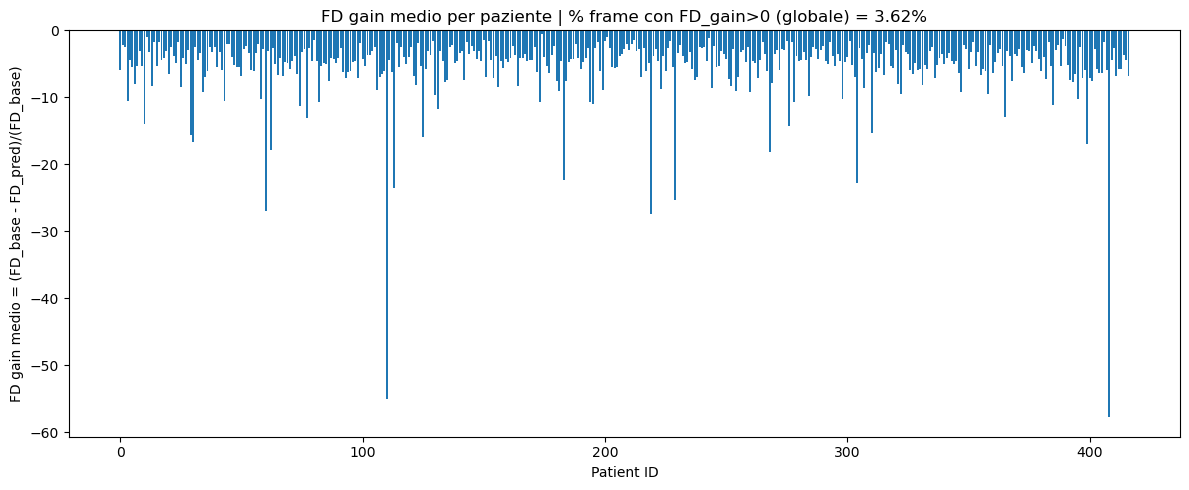

In [7]:
# === FD GAIN per paziente (coerente col tuo flusso) ===
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os, torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

def fd_from_true_pred(y_true_inv, y_pred_inv, head_radius_mm=50.0):
    """
    FD tra due sequenze [Nwin, 6] in unità fisiche:
      - prime 3 colonne: traslazioni (mm)
      - ultime 3 colonne: rotazioni (RAD)
    Formula FD = |Δx|+|Δy|+|Δz| + R*|Δrot_x| + R*|Δrot_y| + R*|Δrot_z|
    dove R=head_radius_mm.
    Ritorna un vettore [Nwin] (frame/finestre).
    """
    diffs = y_true_inv[:, :3] - y_pred_inv[:, :3]
    rot_diffs = y_true_inv[:, 3:] - y_pred_inv[:, 3:]  # già in RAD
    rot_disp = head_radius_mm * np.abs(rot_diffs)
    return np.sum(np.abs(diffs), axis=1) + np.sum(rot_disp, axis=1)

patient_mean_fd_gain = []
patient_pct_pos = []
_all_fd_gains = []

for pid in range(len(test_data)):
    # DataLoader per SINGOLO paziente, baseline = ultimo frame della finestra (come fai tu)
    ds = TimeSeriesDataset(test_data[pid:pid+1, :, :], TRANSFORM=False)
    loader = DataLoader(ds, batch_size=len(ds), shuffle=False)
    x_np, y_np = next(iter(loader))            # x:[Nwin,T,D], y:[Nwin,D]
    x = x_np.to(device).float()
    y = y_np.to(device).float()

    with torch.no_grad():
        y_hat, _ = model(x)                    # [Nwin, D]
        baseline = x[:, -1, :]                 # [Nwin, D]

    # -> numpy
    y_true = y.cpu().numpy()
    y_pred = y_hat.cpu().numpy()
    base   = baseline.cpu().numpy()

    # Denormalizza con i tuoi scaler (stesso metodo che usi ovunque)
    y_true_inv = np.zeros_like(y_true)
    y_pred_inv = np.zeros_like(y_pred)
    base_inv   = np.zeros_like(base)
    for d_idx in range(len(scalers)):
        y_true_inv[:, d_idx] = scalers[d_idx].inverse_transform(y_true[:, d_idx].reshape(-1,1)).ravel()
        y_pred_inv[:, d_idx] = scalers[d_idx].inverse_transform(y_pred[:, d_idx].reshape(-1,1)).ravel()
        base_inv[:, d_idx]   = scalers[d_idx].inverse_transform(base[:,   d_idx].reshape(-1,1)).ravel()

    # FD e FD gain (ESATTAMENTE come nel tuo codice)
    fd_pred = fd_from_true_pred(y_true_inv, y_pred_inv)   # [Nwin]
    fd_base = fd_from_true_pred(y_true_inv, base_inv)     # [Nwin]
    fd_gain = (fd_base - fd_pred) / (fd_base + 1e-6)      # normalizzato

    patient_mean_fd_gain.append(fd_gain.mean())
    patient_pct_pos.append((fd_gain > 0).mean() * 100.0)
    _all_fd_gains.append(fd_gain)

patient_mean_fd_gain = np.array(patient_mean_fd_gain)
patient_pct_pos = np.array(patient_pct_pos)
_all_fd_gains = np.concatenate(_all_fd_gains, axis=0)
global_pct_pos = (_all_fd_gains > 0).mean() * 100.0

# Etichette asse x
x_labels = (test_ids.astype(str) if 'test_ids' in globals() or 'test_ids' in locals()
            else np.array([str(i) for i in range(len(test_data))]))

# --- Plot 1 (scatter pred vs real) lo hai già in tester.evaluate() ---

# --- Plot 2: FD gain medio per paziente + % globale frame con FD_gain>0 ---
plt.figure(figsize=(12, 5))
plt.bar(np.arange(len(patient_mean_fd_gain)), patient_mean_fd_gain)
#plt.xticks(np.arange(len(x_labels)), x_labels, rotation=90)
plt.ylabel("FD gain medio = (FD_base - FD_pred)/(FD_base)")
plt.xlabel("Patient ID")
plt.title(f"FD gain medio per paziente | % frame con FD_gain>0 (globale) = {global_pct_pos:.2f}%")
plt.tight_layout()

out_dir = f'output-file/{args.dataset.replace(".npy","")}'
os.makedirs(out_dir, exist_ok=True)
plt.savefig(f'{out_dir}/fd_gain_medio_per_paziente.png')
plt.close()

# (Opzionale) stampa percentuale per paziente
print("Percentuale di frame con FD_gain>0 per paziente (in %):")
for lab, pct, mg in zip(x_labels, patient_pct_pos, patient_mean_fd_gain):
    print(f"  {lab}: {pct:.2f}%  | FD_gain medio = {mg:.4f}")
print(f"\nPercentuale GLOBALE di frame con FD_gain>0: {global_pct_pos:.2f}%")


In [ ]:
print(f"Total number of WM samples: {len(wm_all)}") #wmall=430 
print(f"Number of training samples in WM: {len(wm_train)}") #w_train=344

print(f"equivalente wmall: {train_data.shape[0]+test_data.shape[0]+val_data.shape[0]}")
print(f"equivalente wm_train: {train_data.shape[0]}")

#wm_all= train_data.shape[0]+test_data.shape[0]+val_data.shape[0]
#wm_train=train_data.shape[0]
#wm_test=test_data.shape[0]

In [ ]:
print(f"Batch size: {BATCH_SIZE}")


In [ ]:
def evaluate_fd_gain(model, loader, scalers):
    device = next(model.parameters()).device
    mu = torch.tensor([s.mean_[0] for s in scalers], device=device)
    sig = torch.tensor([s.scale_[0] for s in scalers], device=device)

    def fd(a, b):
        a = a * sig - mu
        b = b * sig - mu
        return (torch.abs(a[:, :3] - b[:, :3]).sum(1) +
                50 * torch.abs(a[:, 3:] - b[:, 3:]).sum(1))

    gains = []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_hat, _ = model(x)

            # Calcola il FD-gain per ciascun campione
            fdg = (fd(y, x[:, -1, :]) - fd(y, y_hat)) / (fd(y, x[:, -1, :]) + 1e-6)
            gains.append(fdg.cpu().numpy())

    # Concatenate i guadagni per tutti i campioni
    gains = np.concatenate(gains)
    print(f"Total number of gains: {len(gains)}")  # Questo dovrebbe essere 12900 guadagni totali (per tutti i campioni)

    # Calcola il numero di pazienti nel test set
    N_pat = len(wm_test)  # Numero di pazienti nel test set (43 pazienti)
    print(f"Number of patients (N_pat): {N_pat}")

    # Calcola quanti campioni per paziente
    num_samples_per_patient = len(gains) // N_pat  # Calcola il numero di campioni per paziente
    print(f"Number of samples per patient: {num_samples_per_patient}")  # Dovresti vedere un numero maggiore di 1

    # Raggruppa i guadagni per paziente
    gains_patient = []
    for i in range(N_pat):
        start_idx = i * num_samples_per_patient
        end_idx = (i + 1) * num_samples_per_patient
        gains_patient.append(np.mean(gains[start_idx:end_idx]))  # Calcola la media per ciascun paziente

    gains_patient = np.array(gains_patient)  # Converti la lista in un array

    return gains_patient



In [ ]:
from torch.utils.data import DataLoader

# Creazione dei DataLoader per il training set e il test set
wm_train_loader = DataLoader(TimeSeriesDataset(wm_train), batch_size=32, shuffle=False)
wm_test_loader = DataLoader(TimeSeriesDataset(wm_test), batch_size=32, shuffle=False)


In [ ]:
# Carica i pesi del modello fine-tunato
model.load_state_dict(torch.load(f'{CHK_DIR}/model_general.pth'))


In [ ]:
# Calcola il FD-gain per il test set (per paziente)
FD_A_patient = evaluate_fd_gain(model, wm_test_loader, scalers)
print(f"FD_A_patient length: {len(FD_A_patient)}")  # Dovrebbe essere 43

# Calcola il FD-gain per il training set (per paziente)
FD_B_patient = evaluate_fd_gain(model, wm_train_loader, scalers)
print(f"FD_B_patient length: {len(FD_B_patient)}")  # Dovrebbe essere 344




In [ ]:
import pandas as pd

# Creazione del DataFrame con i risultati
df = pd.DataFrame({
    'patient_id': list(range(len(FD_A_patient))),
    'FD_gain_A': FD_A_patient,
    'FD_gain_B': FD_B_patient,
    'FD_gain_C': FD_C_patient  # Assicurati che anche FD_C_patient sia stato calcolato
})

# Salva il CSV
csv_path = f'{DATA_DIR}/benchmark_generalista.csv'
df.to_csv(csv_path, index=False)

print("💾 Benchmark salvato in:", csv_path)
display(df.head())  # Mostra le prime righe del DataFrame


In [ ]:
from google.colab import drive
drive.mount('/content/drive')